In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/concrete/sample_submission.csv
/kaggle/input/concrete/train.csv
/kaggle/input/concrete/test.csv
/kaggle/input/concrete-strength-regression-dataset/train.csv
/kaggle/input/concrete-strength-regression-dataset/test.csv


# 1. 연구목표수립

다양한 요소들이 콘크리트 강도 ( Concrete Strengh) 와 얼마나 연관되어 있으며 이를 통해 Regression(회귀) 모델의 이해를 우선시한다. <br>
더 나아가 다양한 모델들을 활용하여 feature에 따른 콘크리트 강도(target)을 예상해본다.

# 2. 데이터 준비

In [120]:
# 기본 모듈 볼러오기
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

## 데이터 set 불러오기

In [121]:
train = pd.read_csv('/kaggle/input/concrete-strength-regression-dataset/train.csv')
test  = pd.read_csv('/kaggle/input/concrete-strength-regression-dataset/test.csv')
submission = pd.read_csv('/kaggle/input/concrete/sample_submission.csv')
train.shape, test.shape, submission.shape

((5407, 10), (3605, 9), (3605, 2))

In [122]:
# 피처확인
print(train.columns)
print(test.columns)
#  test 데이터에서 'Strength'는  submission에 있음
print(submission.columns)

Index(['id', 'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')
Index(['id', 'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'],
      dtype='object')
Index(['id', 'Strength'], dtype='object')


In [123]:
train.describe()
'''
    id : 번호 -> 제거
    Strength : 타겟값
    나머지 피처 : 연속형 데이터
    CementComponent (시멘트 성분):
    BlastFurnaceSlag (고로슬래그 성분): 고로슬래그는 철 제련 과정에서 발생하는 부산물로, 콘크리트의 강도 향상 및 내화성
    FlyAshComponent (플라이 애쉬 성분): 화력 발전소에서 생성되는 부산물
    WaterComponent (물 성분):
    SuperplasticizerComponent (고효율 플라스틱라이저 성분): 이 성분은 콘크리트를 미세하게 조절하고 흐름을 향상시키는 데 사용
    CoarseAggregateComponent (굵은 골재 성분):
    FineAggregateComponent (미세 골재 성분):
    AgeInDays (콘크리트 나이):
'''
# 75%에 비해 확연히 높은 max가 눈에 보이지만 우선 그대로 둔다.

'\n    id : 번호 -> 제거\n    Strength : 타겟값\n    나머지 피처 : 연속형 데이터\n    CementComponent (시멘트 성분):\n    BlastFurnaceSlag (고로슬래그 성분): 고로슬래그는 철 제련 과정에서 발생하는 부산물로, 콘크리트의 강도 향상 및 내화성\n    FlyAshComponent (플라이 애쉬 성분): 화력 발전소에서 생성되는 부산물\n    WaterComponent (물 성분):\n    SuperplasticizerComponent (고효율 플라스틱라이저 성분): 이 성분은 콘크리트를 미세하게 조절하고 흐름을 향상시키는 데 사용\n    CoarseAggregateComponent (굵은 골재 성분):\n    FineAggregateComponent (미세 골재 성분):\n    AgeInDays (콘크리트 나이):\n'

In [124]:
test.describe()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
count,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000
mean,7209.000000,299.943523,55.803273,32.829154,184.345825,4.194230,990.222330,774.736311,49.153398
std,1040.818188,104.809283,80.938863,55.490684,17.964842,5.807567,76.812197,77.412505,63.564334
min,5407.000000,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,6308.000000,213.800000,0.000000,0.000000,174.900000,0.000000,938.200000,739.300000,7.000000
50%,7209.000000,300.000000,0.000000,0.000000,188.500000,0.000000,977.600000,781.500000,28.000000
75%,8110.000000,374.000000,117.200000,90.000000,192.000000,8.100000,1047.000000,821.000000,56.000000
max,9011.000000,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000


## 데이터클리닝(null값(결측치), 이상치 제거)

In [125]:
train.isnull().sum().values


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [126]:
test.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [127]:
train.info(), test.info()
# 개수에서 결측치없음을 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 422.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  --

(None, None)

## EDA

### id

In [128]:
# id는 영향력이 없는 피처이므로 제거

train = train.drop(columns = ['id'])
train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [129]:
test = test.drop(columns = ['id'])
test

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
0,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56
1,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7
2,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28
3,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
4,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28
...,...,...,...,...,...,...,...,...
3600,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28
3601,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28
3602,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28
3603,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3


## 히스토그램으로 각 피처들의 특징 파악

<Axes: xlabel='AgeInDays', ylabel='Count'>

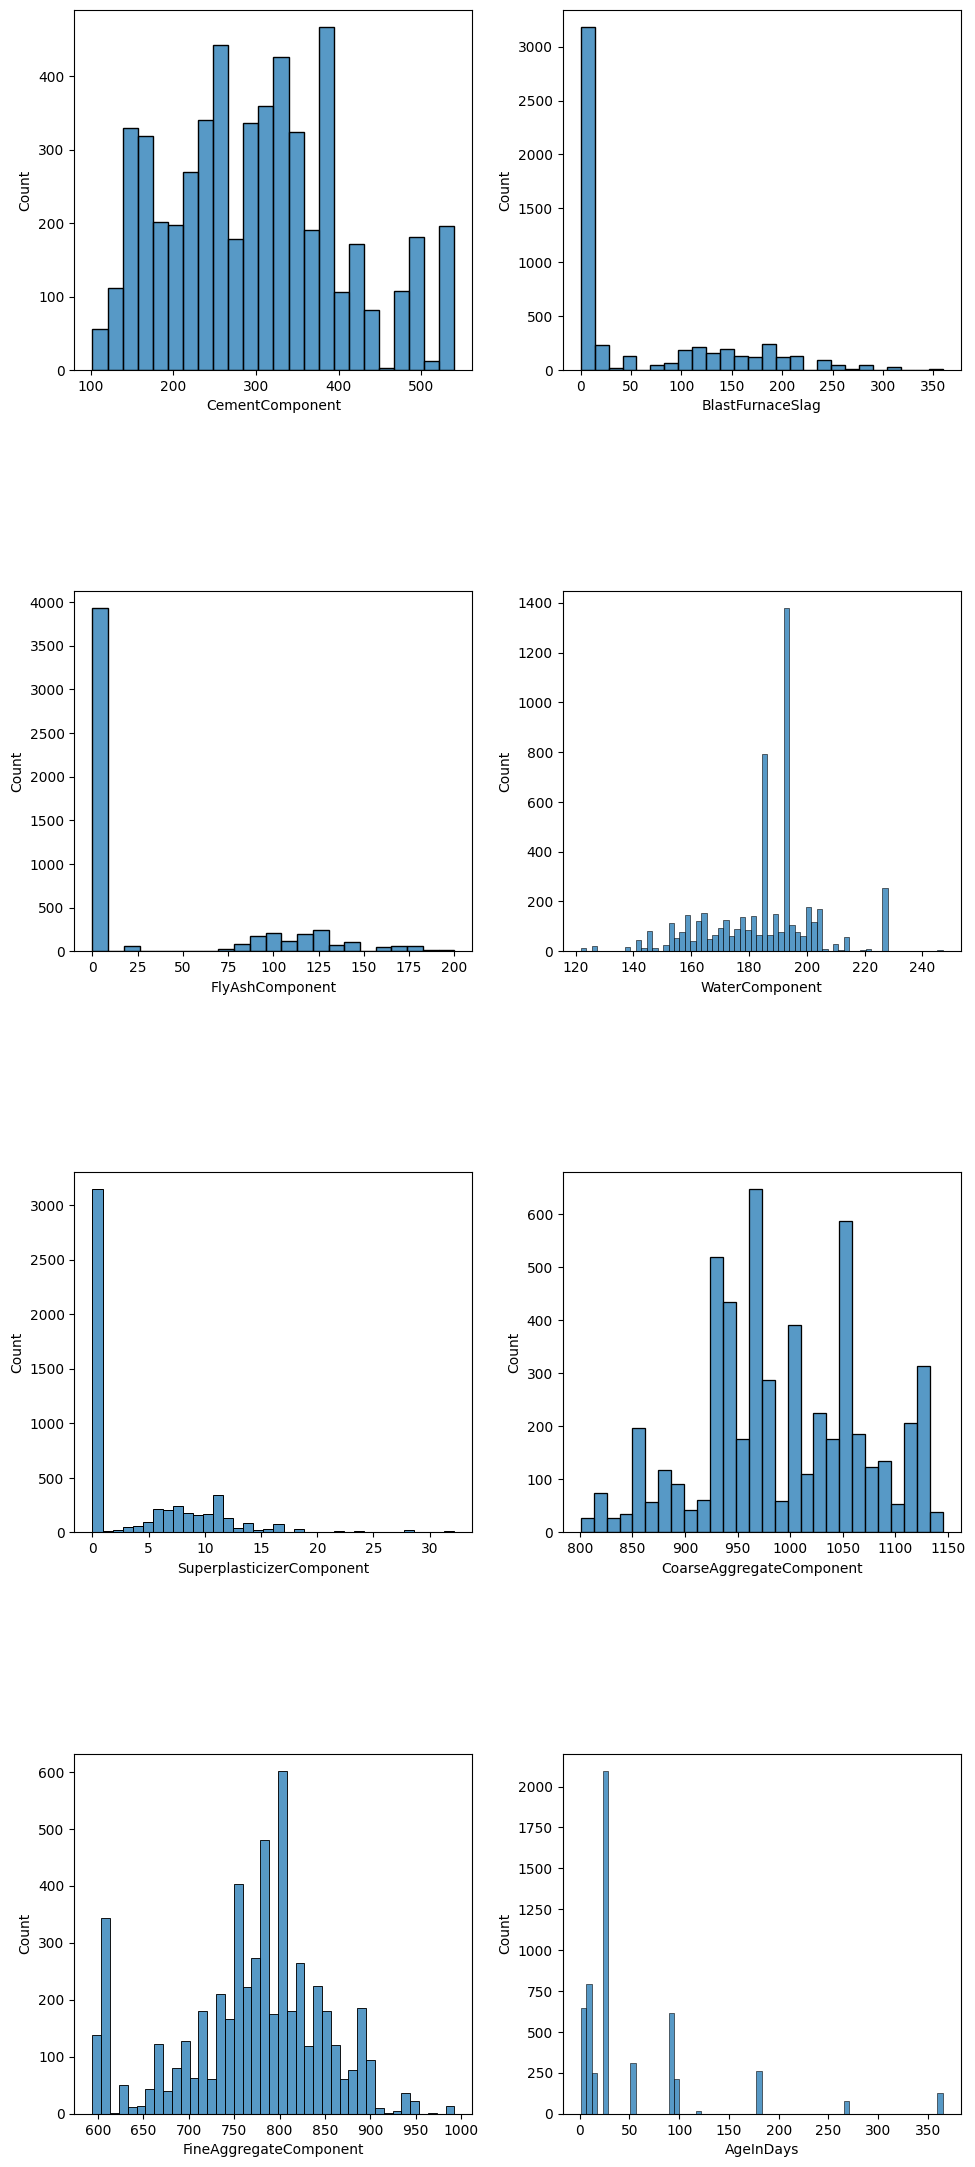

In [130]:

nrows , ncols= 4 , 2
fig, axes = plt.subplots( nrows= nrows, ncols=ncols)
plt.tight_layout()
fig.set_size_inches(5*ncols, 6*nrows)

sns.histplot(data= train, x=train['CementComponent'], ax= axes[0,0])
sns.histplot(data= train, x=train['BlastFurnaceSlag'], ax= axes[0,1])
sns.histplot(data= train, x=train['FlyAshComponent'], ax= axes[1,0])
sns.histplot(data= train, x=train['WaterComponent'], ax= axes[1,1])
sns.histplot(data= train, x=train['SuperplasticizerComponent'], ax= axes[2,0])
sns.histplot(data= train, x=train['CoarseAggregateComponent'], ax= axes[2,1])
sns.histplot(data= train, x=train['FineAggregateComponent'], ax= axes[3,0])
sns.histplot(data= train, x=train['AgeInDays'], ax= axes[3,1])



이상치나, 외도 가 큰 데이터가 많기 때문에 robustscaler를 전체데이터에 사용하였다.

In [131]:
train.columns

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')

BlastFurnaceSlag, FlyAshComponent, WaterComponent, SuperplasticizerComponent, FineAggregateComponent, AgeInDays 는 외도가 크고 이상치가 있으므로 robust scaler를 사용한다

In [132]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
train['BlastFurnaceSlag'] = scaler.fit_transform(train[['BlastFurnaceSlag']])
train['FlyAshComponent'] = scaler.fit_transform(train[['FlyAshComponent']])
train['WaterComponent'] = scaler.fit_transform(train[['WaterComponent']])
train['SuperplasticizerComponent'] = scaler.fit_transform(train[['SuperplasticizerComponent']])
train['FineAggregateComponent'] = scaler.fit_transform(train[['FineAggregateComponent']])
train['AgeInDays'] = scaler.fit_transform(train[['AgeInDays']])

train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.000000,0.000000,-0.082840,0.000000,1125.0,-1.940023,-0.510204,10.38
1,143.0,1.378467,1.810127,0.213018,0.993789,967.0,-1.594002,0.000000,23.52
2,289.0,1.098695,0.000000,-0.100592,0.000000,1075.0,0.162630,0.000000,36.96
3,304.0,0.619902,0.000000,2.402367,0.000000,932.0,-1.282584,6.877551,39.05
4,157.0,1.924959,0.000000,0.272189,0.000000,935.4,0.000000,1.265306,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,0.195759,1.000000,-1.502959,1.440994,967.0,-0.798155,-0.510204,15.42
5403,350.0,0.000000,0.000000,0.923077,0.000000,974.0,-0.071511,3.102041,49.20
5404,295.8,0.000000,0.000000,-0.100592,0.000000,1076.2,-0.252595,0.000000,39.30
5405,376.0,0.761827,0.000000,-1.467456,1.428571,955.8,-1.364475,0.000000,39.61


In [133]:
train['BlastFurnaceSlag']

0       0.000000
1       1.378467
2       1.098695
3       0.619902
4       1.924959
          ...   
5402    0.195759
5403    0.000000
5404    0.000000
5405    0.761827
5406    0.000000
Name: BlastFurnaceSlag, Length: 5407, dtype: float64

## 피처요약표

In [134]:
def summary_feature_info( df ):
    '''
        피처명, 형상, 타입, 결측치, 고유값수, 샘플값 구성된 df를 리턴한다
        id : 0 ~ 5407의 고유한 숫자 -> 영향력없음
        나머지 feature : 연속형 데이터로 구성되어 있다. 다만 수치가 제각각이기 때문에 스케일링이 필요하다고 생각된다.
        
    '''
    # df.dtypes 인덱스명 그대로 인덱스, 타입이 컬럼으로 설정
    sub_df = pd.DataFrame( df.dtypes, columns=['type'])
    sub_df.rename( columns={'index':'feature_name'}, inplace=True)
    sub_df['결측치수'] = df.isnull().sum().values
    sub_df['고유값수'] = df.nunique().values
    sub_df['샘플값_0'] = df.loc[0].values
    sub_df['샘플값_1'] = df.loc[1].values
    sub_df['샘플값_2'] = df.loc[2].values
    return sub_df

summary_feat_df = summary_feature_info( train )
summary_feat_df
# 고유값수가 많다. -> 연속형 데이터다.

,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
CementComponent,float64,0,314,525.000000,143.000000,289.000000
BlastFurnaceSlag,float64,0,224,0.000000,1.378467,1.098695
FlyAshComponent,float64,0,177,0.000000,1.810127,0.000000
WaterComponent,float64,0,215,-0.082840,0.213018,-0.100592
SuperplasticizerComponent,float64,0,112,0.000000,0.993789,0.000000
CoarseAggregateComponent,float64,0,342,1125.000000,967.000000,1075.000000
FineAggregateComponent,float64,0,376,-1.940023,-1.594002,0.162630
AgeInDays,float64,0,15,-0.510204,0.000000,0.000000
Strength,float64,0,843,10.380000,23.520000,36.960000


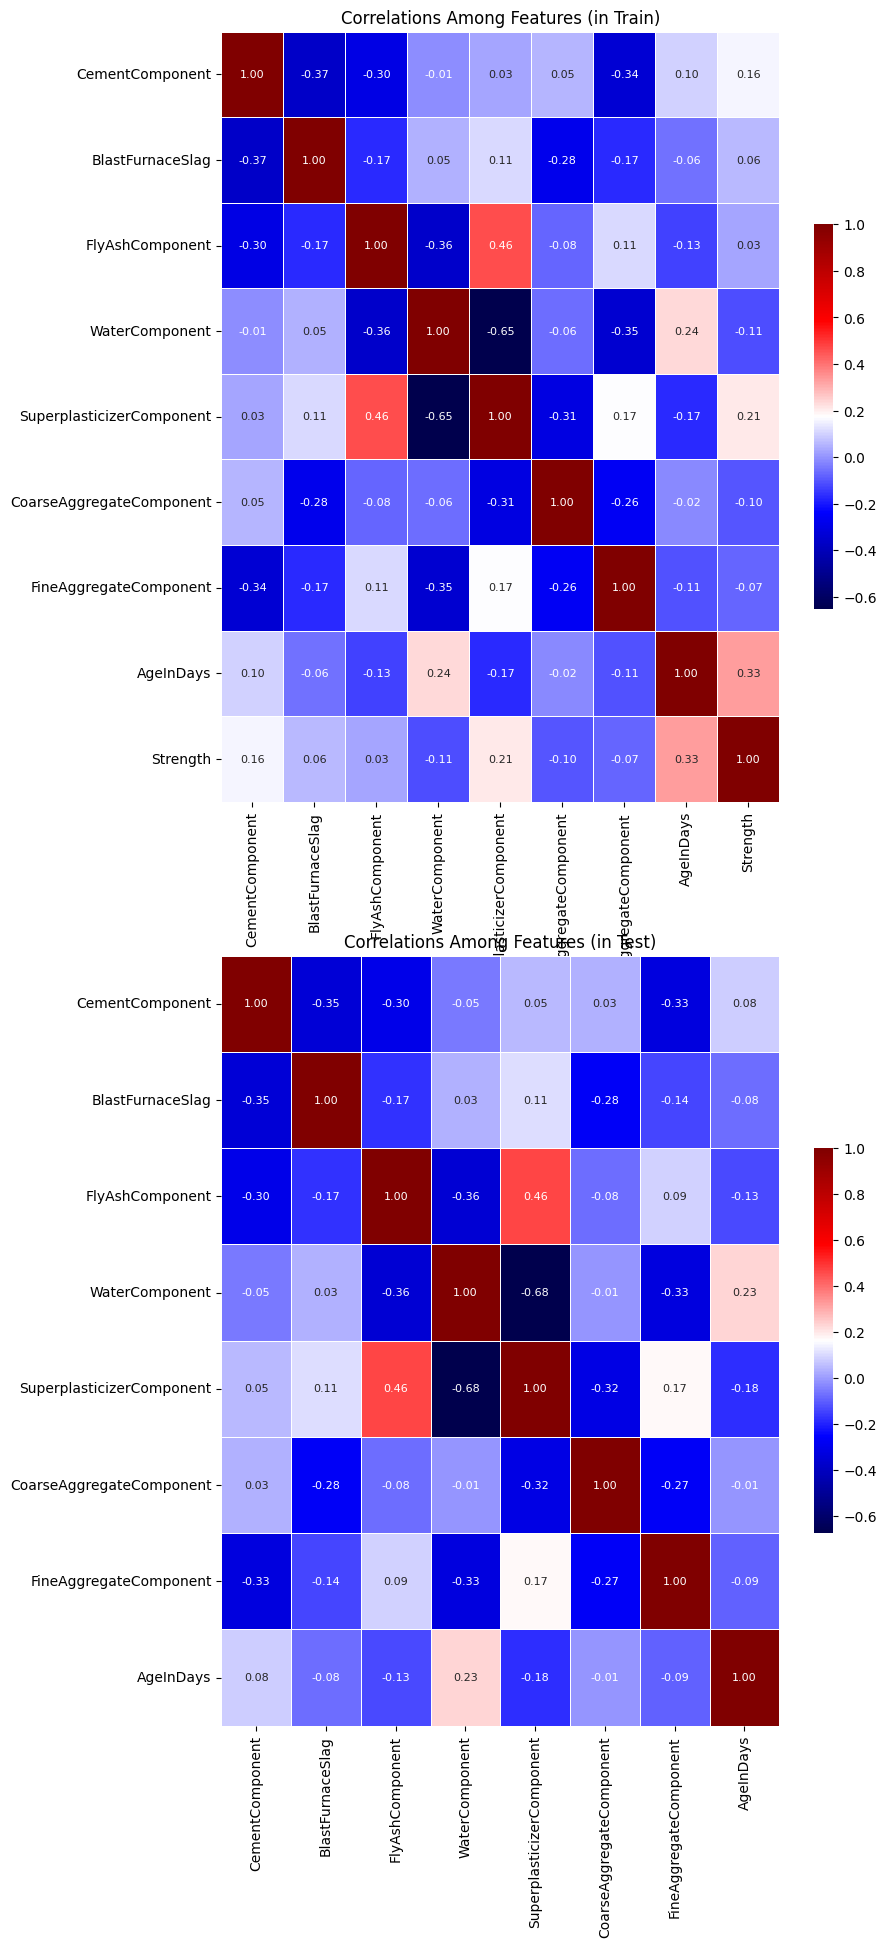

In [135]:
corr_mat_train = train.corr()
corr_mat_test = test.corr()

fig, axes = plt.subplots(2, 1, figsize = (9, 22))
sns.heatmap(corr_mat_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_mat_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

# 상관계수가 0.9 이상 되면 제거, 하지만 그런 피처는 없음.
# Strength 의 AgelnDays,Superplasticizer순으로 영향을 많이 미쳤다.
# 하지만 test data에는 영향을 미친 것이 다르기 때문에 단순 특정요소가 많이 영향을 미친다고 강도에 직접적으로 영향을 주진 않는다고 생각한다.


## 타겟데이터 + displot

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


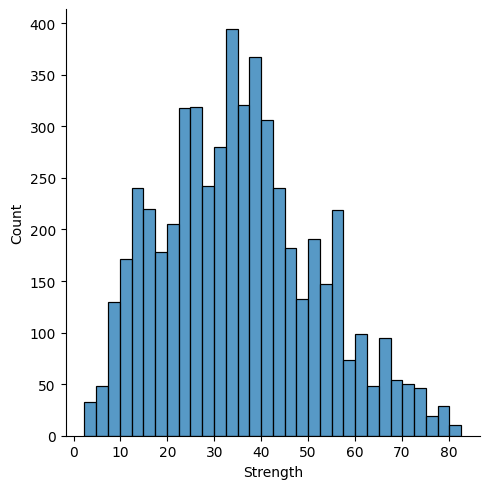

In [137]:
sns.displot(train['Strength']);

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


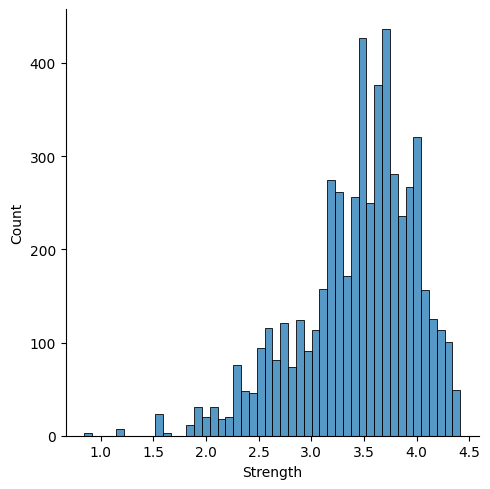

In [138]:
# 로그처리 
sns.displot(np.log(train.Strength));
# 오히려 로그처리를 하니 정규분포와 멀어졌다고 판단된다.

## 연속형 데이터 시각화

In [139]:
train.info()
# train의 7개 피처중 0~7번 피처는 연속형 데이터로 되어있으며 8번째피처(Strength)는 타겟값(y)이다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            5407 non-null   float64
 1   BlastFurnaceSlag           5407 non-null   float64
 2   FlyAshComponent            5407 non-null   float64
 3   WaterComponent             5407 non-null   float64
 4   SuperplasticizerComponent  5407 non-null   float64
 5   CoarseAggregateComponent   5407 non-null   float64
 6   FineAggregateComponent     5407 non-null   float64
 7   AgeInDays                  5407 non-null   float64
 8   Strength                   5407 non-null   float64
dtypes: float64(9)
memory usage: 380.3 KB


<Axes: >

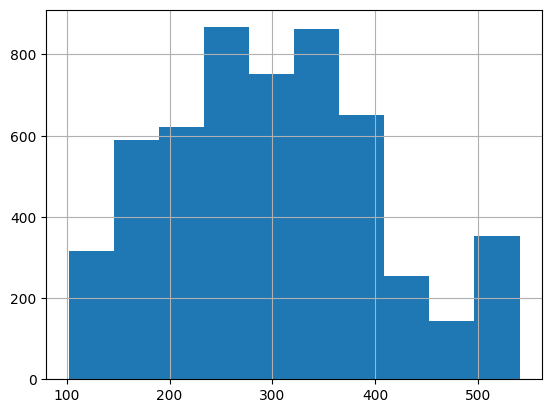

In [140]:
train['CementComponent'].hist()

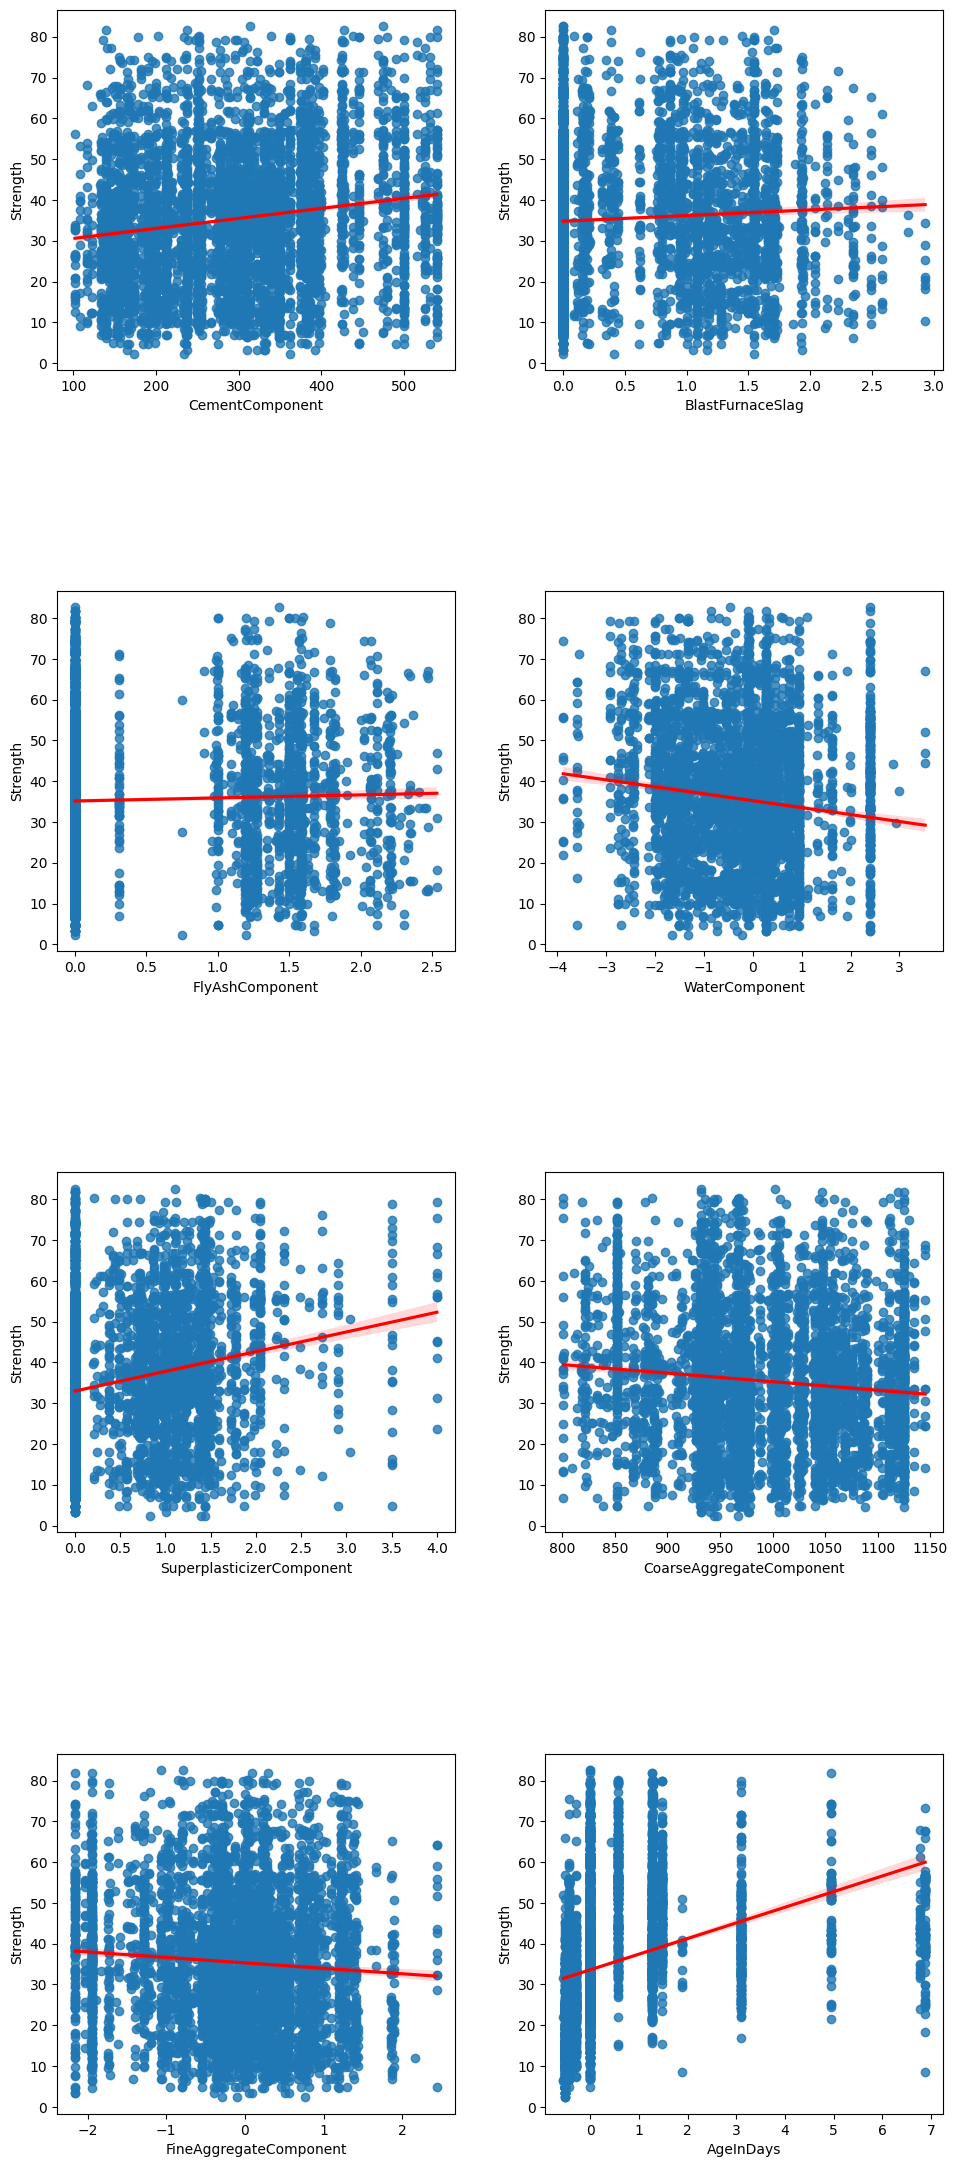

In [141]:
nrows , ncols= 4 , 2
fig, axes = plt.subplots( nrows= nrows, ncols=ncols)
plt.tight_layout()
fig.set_size_inches(5*ncols, 6*nrows)

# 회귀선 색상 변경, 포인트 투명도 조정 -> 밀집형태를 조정
sns.regplot(x='CementComponent', y='Strength', data=train, ax=axes[0, 0], line_kws={'color': 'red'}
            );
sns.regplot(x='BlastFurnaceSlag', y='Strength', data=train, ax=axes[0, 1], line_kws={'color': 'red'}
            );
sns.regplot(x='FlyAshComponent', y='Strength', data=train, ax=axes[1, 0], line_kws={'color': 'red'}
            );
sns.regplot(x='WaterComponent', y='Strength', data=train, ax=axes[1, 1], line_kws={'color': 'red'}
            );
sns.regplot(x='SuperplasticizerComponent', y='Strength', data=train, ax=axes[2, 0], line_kws={'color': 'red'}
            );
sns.regplot(x='CoarseAggregateComponent', y='Strength', data=train, ax=axes[2, 1], line_kws={'color': 'red'}
            );
sns.regplot(x='FineAggregateComponent', y='Strength', data=train, ax=axes[3, 0], line_kws={'color': 'red'}
            );
sns.regplot(x='AgeInDays', y='Strength', data=train, ax=axes[3, 1], line_kws={'color': 'red'}
            );

plt.show()

In [142]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# scaler = StandardScaler()
scaler = RobustScaler()


# 3. 모델구축

In [143]:
import pandas as pd
X = train.iloc[:, :-1 ]
y = train.iloc[:, -1]
y

0       10.38
1       23.52
2       36.96
3       39.05
4       74.19
        ...  
5402    15.42
5403    49.20
5404    39.30
5405    39.61
5406    63.14
Name: Strength, Length: 5407, dtype: float64

In [144]:
# 학습에 사용되는 훈련용, 테스트용 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4055, 8), (1352, 8), (4055,), (1352,))

In [184]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

def cus_rmse( y_true, y_pred, transfer=True):
    '''
        - y_true:실제값, 정답
        - y_pred:예측값
        - transfer: True-로그처리된값->복원->np.exp()
    '''
    # 원래값 복원
    if transfer:
        y_true = np.exp( y_true )
        y_pred = np.exp( y_pred )

    # 로그변환
    # 로그변환후 결측치 발생 하면 0으로 보정 처리하는 함수 활용
    #log_y_true = np.nan_to_num( np.log(y_true+1) )
    #log_y_pred = np.nan_to_num( np.log(y_pred+1) )
    # 변환 전에 값이 너무 작으면 컴퓨터 계산산 오류 발생소지가 있음 => 보정 log1p()
    # log1p이 더 안정적임
    log_y_true = np.nan_to_num( np.log1p(y_true) )
    log_y_pred = np.nan_to_num( np.log1p(y_pred) )

    # RMSLE 처리
    return  np.mean( (log_y_true - log_y_pred)**2 ) 

In [146]:
from sklearn.linear_model import LinearRegression
# 알고리즘 생성
lr_model = LinearRegression()
# 정답데이터 변환
# log_y    = np.log( y_train )
# 학습
lr_model.fit( X_train, y_train )

LinearRegression()

In [150]:
# 예측
y_pred = lr_model.predict(X_test)
# 평가
cus_rmsle(y_test, y_pred)

14.387502693971838

In [152]:
X_test

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
1050,393.0,0.000000,0.000000,0.272189,0.000000,940.6,0.050750,0.000000
2579,144.0,1.468189,1.518987,1.455621,1.366460,878.0,-0.613610,0.000000
5043,298.0,1.533442,1.349367,1.319527,0.757764,878.6,0.032295,0.000000
3975,375.0,0.765090,0.000000,-3.597633,2.906832,852.1,2.438293,0.000000
1828,230.0,0.000000,1.497468,0.491124,0.571429,1029.4,-0.260669,1.469388
...,...,...,...,...,...,...,...,...
1393,355.9,0.000000,0.000000,-0.745562,1.130435,1030.0,-0.319493,0.000000
4365,307.0,0.000000,0.000000,0.331361,0.000000,968.0,0.355248,-0.428571
3582,289.0,0.000000,0.000000,0.272189,0.000000,965.4,0.288351,-0.510204
4255,491.0,0.213703,0.000000,-2.934911,0.509317,852.1,1.297578,0.571429


In [148]:
sub_y_pred = lr_model.predict( test )
submission['Strength'] = sub_y_pred
submission.to_csv( 'Concrete_submission_v1.csv', index=False )

In [149]:
%pwd

'/kaggle/working'

# Catboost Model 

In [ ]:
# from sklearn.model_selection import train_test_split
# import catboost
# from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import cross_val_score

# def xgboost_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.05)
#     depth = trial.suggest_int('depth', 3, 10)
# #     subsample = trial.suggest_float('subsample', 0.5, 1)
# #     reg = trial.suggest_float('reg', 0, 1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     model = catboost.CatBoostRegressor(
#                iterations = 2000, 
#                learning_rate = learning_rate,
#                max_depth = depth,
#                verbose=1000,
#                subsample = 0.6215023014443006,
#                l2_leaf_reg=0.7998684766493955,
#     )
    
#     model.fit(X_train, y_train)  

# #     kf = KFold(n_splits= 5)
# #     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return mean_squared_error(y_test, model.predict(X_test), squared=False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(xgboost_objective, n_trials= 50)

In [153]:
!pip install catboost

In [163]:
column_names = X_train.columns.tolist()
column_names

['CementComponent',
 'BlastFurnaceSlag',
 'FlyAshComponent',
 'WaterComponent',
 'SuperplasticizerComponent',
 'CoarseAggregateComponent',
 'FineAggregateComponent',
 'AgeInDays']

In [174]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
cat_model.fit(X_train, y_train)

0:	learn: 15.2152280	total: 2.73ms	remaining: 2.73s
1:	learn: 14.3142949	total: 4.55ms	remaining: 2.27s
2:	learn: 13.7551874	total: 6.27ms	remaining: 2.08s
3:	learn: 13.2656923	total: 8.02ms	remaining: 2s
4:	learn: 12.9358050	total: 9.78ms	remaining: 1.95s
5:	learn: 12.6836558	total: 11.6ms	remaining: 1.93s
6:	learn: 12.5081489	total: 13.4ms	remaining: 1.9s
7:	learn: 12.3737233	total: 15.2ms	remaining: 1.89s
8:	learn: 12.2909249	total: 17.1ms	remaining: 1.89s
9:	learn: 12.2000372	total: 19.1ms	remaining: 1.89s
10:	learn: 12.1253097	total: 20.9ms	remaining: 1.88s
11:	learn: 12.0586984	total: 22.8ms	remaining: 1.88s
12:	learn: 12.0190143	total: 24.8ms	remaining: 1.88s
13:	learn: 11.9959576	total: 26.8ms	remaining: 1.89s
14:	learn: 11.9458219	total: 39.4ms	remaining: 2.58s
15:	learn: 11.9091881	total: 41.7ms	remaining: 2.56s
16:	learn: 11.8945494	total: 43.9ms	remaining: 2.54s
17:	learn: 11.8666799	total: 46.3ms	remaining: 2.53s
18:	learn: 11.8425386	total: 48.7ms	remaining: 2.51s
19:	lea

In [185]:
# 예측
y_pred = model.predict(X_test)
# 평가
cus_rmse(y_test, y_pred)

154.4879083325543

In [179]:
test  = pd.read_csv('/kaggle/input/concrete-strength-regression-dataset/test.csv')
submission = pd.read_csv('/kaggle/input/concrete/sample_submission.csv')
sub_y_pred = model.predict( test )
submission['Strength'] = sub_y_pred
submission.to_csv( 'Concrete_submission_v4.csv', index=False )

In [180]:
submission['Strength']

0       52.564978
1       47.207078
2       48.472473
3       58.092612
4       52.808620
          ...    
3600    52.393850
3601    40.151073
3602    62.293156
3603    61.196810
3604    64.872312
Name: Strength, Length: 3605, dtype: float64